In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from piecewise import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Settings

In [2]:
NP_DTYPE = np.float32

## Testing

In [5]:
tf.enable_eager_execution()

In [6]:
test = PiecewiseLinear(6,3,5)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
_________________________________________________________________
reshape (Reshape)            (None, 3, 5)              0         
Total params: 5,391
Trainable params: 5,391
Non-trainable params: 0
_________________________________________________________________


In [21]:
val = np.array(np.random.rand(1000000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))

True


In [26]:
np.allclose(test.forward_log_det_jacobian(val,event_ndims=1),-test.inverse_log_det_jacobian(forward,event_ndims=1))

False

In [11]:
test = PiecewiseQuadratic(6,3,5)

In [20]:
val = np.array(np.random.rand(1000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))
print(((val-inverse.numpy())/val)[np.logical_not(np.isclose(val,inverse.numpy()))])

True
[]


## Training

In [27]:
tf.disable_eager_execution()

In [3]:
sess = tf.InteractiveSession()

In [278]:
bijectors = []

for i in range(4):
    bijectors.append(PiecewiseLinear(2,1,32,layer_id=i))
    bijectors.append(tfb.Permute(permutation=[1,0]))

# Discard the last Permute layer
test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
test_bijector.forward_min_event_ndims

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 32)             0         
Total params: 6,368
Trainable params: 6,368
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 

1

In [279]:
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
base_dist = tfd.Independent(distribution=base_dist,
                           reinterpreted_batch_ndims=1,
                           )
#base_dist = tfd.MultivariateNormalDiag(loc=[0., 0.])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector,
)

base_dist

<tfp.distributions.Independent 'IndependentUniform_1/' batch_shape=() event_shape=(2,) dtype=float32>

In [280]:
x = base_dist.sample(1000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

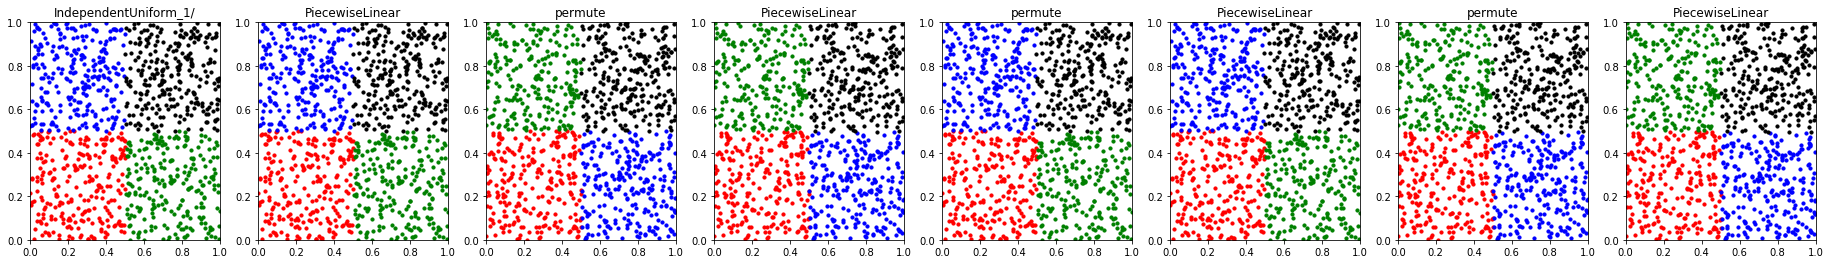

In [281]:
sess.run(tf.global_variables_initializer())
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [282]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[array([[ 0.04060951,  0.18140012,  0.11394608,  0.08374327, -0.2040322 ,
         0.2623794 , -0.06385003,  0.13393971, -0.20038073, -0.04917216,
        -0.15222195, -0.11389768,  0.16527113, -0.13026528, -0.28004465,
         0.27740687, -0.15649782, -0.04674894,  0.15287372, -0.28266403,
         0.25421667, -0.1652092 ,  0.1503635 , -0.09953615,  0.24291688,
         0.06415573, -0.24004927, -0.2941773 ,  0.2177763 ,  0.11240223,
        -0.04549617,  0.14606482,  0.07592756,  0.21020585, -0.21062618,
         0.14868334, -0.06881464, -0.20629403, -0.06957601, -0.2870106 ,
        -0.14500543, -0.23455971, -0.3005018 ,  0.05864003,  0.17738995,
         0.02859405,  0.26900566,  0.03461275,  0.16727698, -0.05682874,
        -0.11908647, -0.02113935,  0.15402916,  0.19412681, -0.1171522 ,
        -0.28533593,  0.1893715 ,  0.14869964, -0.15239325, -0.17565943,
         0.14397806,  0.28588206,  0.12656984, -0.18565896]],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 

[array([[-0.2605536 ,  0.00304228,  0.09234795,  0.05537379, -0.26860332,
        -0.24710795,  0.21266782,  0.11551881,  0.11305669,  0.22422498,
         0.28668016,  0.27171284,  0.21061885, -0.25889158, -0.25753132,
        -0.30072564, -0.13360627,  0.23458695,  0.08929947,  0.01549509,
         0.13213065,  0.12713411,  0.08558953,  0.2790727 , -0.07527991,
         0.27748954, -0.173657  , -0.28592354,  0.17291227,  0.08075294,
        -0.06992103,  0.29607028, -0.11073886,  0.09515929, -0.29948488,
        -0.07668294, -0.25409895,  0.24099737,  0.10444832,  0.0044319 ,
        -0.22764991, -0.11685607,  0.27950376, -0.28200248,  0.14437777,
        -0.29667056, -0.2234979 ,  0.0693742 , -0.29359633,  0.20417315,
         0.16119209, -0.26035511,  0.17574006, -0.14480528,  0.21750444,
        -0.20969957, -0.24663356, -0.03183654, -0.11044353, -0.24231191,
        -0.202099  , -0.02652156, -0.04717097, -0.02039009]],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 

In [387]:
def step(x,x0,k=50):
    return (1/2+1/2*tf.tanh(k*(x0-x)))

def dsigmaTrain(x):
    #return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))
    return (x[:,0]**2+x[:,1]**2)/((1-x[:,0])*(1-x[:,1]))*step(x[:,0],0.9)*step(x[:,1],0.9)

def dsigmaTrue(x):
    return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))

def dsigmaTest(x):
    return 10**7*(1+x[:,0]**2)/((90**2-(90*2*(1-x[:,1]))**2)**2+2.5**2*90**2)

In [388]:
x = dist.sample(5000)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = dsigmaTest(x)

xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])

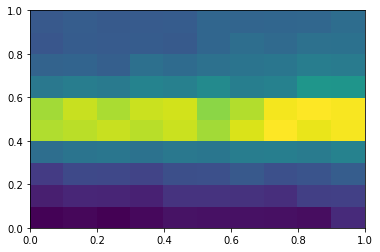

In [389]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts/qPts,norm=mpl.colors.LogNorm())
plt.show()

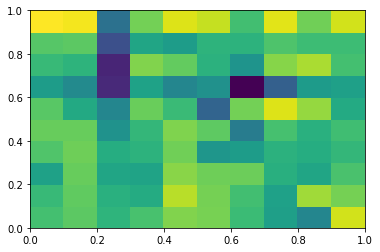

In [390]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=qPts,norm=mpl.colors.LogNorm())
plt.show()

In [391]:
loss = -sess.run(tf.reduce_mean(dsig*X))
print(loss)

-0.8032483


In [414]:
def loss_fn():
    x = dist.sample(1000)
    logq = dist.log_prob(x)
    p = dsigmaTest(x)
    return -tf.reduce_mean(p*logq)

In [415]:
def loss_fn2():
    x = dist.sample(10000)
    q = tf.exp(dist.log_prob(x))
    p = dsigmaTrain(x)
    return tf.reduce_mean(p*p/q)

In [416]:
def loss_fn3():
    x = dist.sample(10000)
    logq = dist.log_prob(x)
    q = tf.exp(logq)
    p = dsigmaTrain(x)
    return -tf.reduce_mean(p*logq)+tf.reduce_mean(p*p/q)

In [417]:
def grad():
    with tf.GradientTape() as tape:
        loss_value = loss_fn()
    return loss_value, tape.gradient(loss_value, bijector.trainable_variables)

In [558]:
loss = loss_fn()
optimizer = tf.train.AdamOptimizer(1e-5,epsilon=1e-4)
grads = optimizer.compute_gradients(loss)
opt_op = optimizer.apply_gradients(grads)
sess.run(tf.global_variables_initializer())

0 0.35403377
500 -1.0947262
1000 -2.3639176
1500 -8.161718
2000 -9.177531
2500 -23.457735
3000 -39.180344


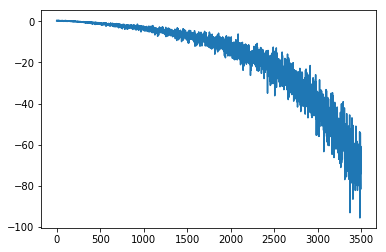

In [559]:
np_losses = []
global_step = []
for epoch in range(3500):
    _, np_loss = sess.run([opt_op, loss])
    global_step.append(epoch)
    np_losses.append(np_loss)
    if epoch % 500 == 0:
        print(epoch, np_loss)
        
start = 0
plt.plot(np_losses[start:])

In [525]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[array([[ 0.16784242, -0.12244384, -0.2846196 , -0.27444428,  0.16603398,
         0.02839788,  0.15755968, -0.03423882, -0.15193307, -0.1606199 ,
         0.04239837,  0.17446683, -0.23961705,  0.32454532, -0.15769005,
         0.17469357,  0.17282006,  0.11251383, -0.1899988 , -0.0086433 ,
         0.10121609, -0.05313578,  0.24315469, -0.17847288,  0.14826395,
         0.0375616 ,  0.01250821, -0.20377214,  0.31097436,  0.18864533,
         0.07033019,  0.1988749 , -0.22654656, -0.24373485, -0.05128574,
        -0.28447685,  0.28991324,  0.06484219,  0.06776263,  0.1487328 ,
        -0.05165416, -0.28134903,  0.11324409,  0.25318334,  0.22062276,
        -0.01042655,  0.19235276,  0.26192817, -0.17611775,  0.16003664,
         0.10496521, -0.0309636 , -0.26856372, -0.03448418, -0.26276833,
        -0.05945407,  0.0481869 , -0.27245358,  0.2646346 , -0.258264  ,
        -0.2052789 , -0.26206243,  0.2428919 , -0.25059012]],
      dtype=float32), array([-0.00315536,  0.        ,  0.   

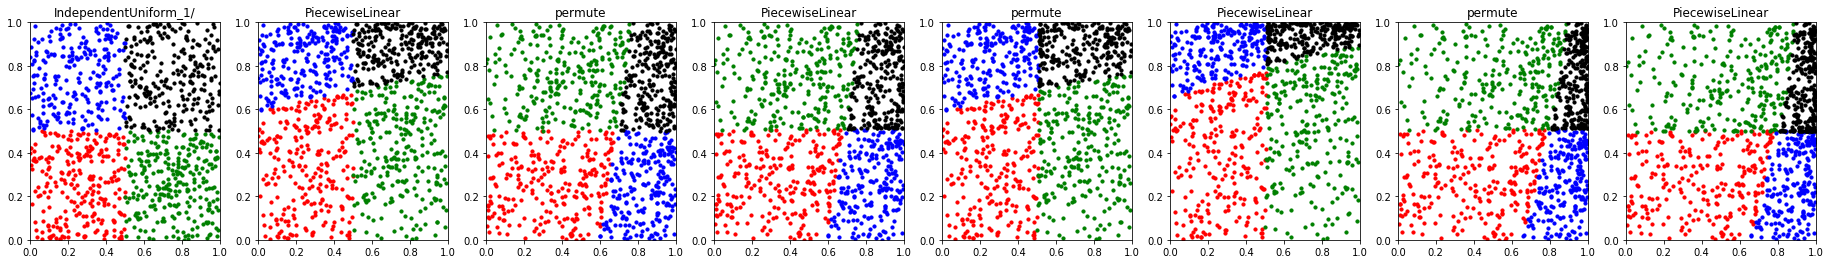

In [560]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

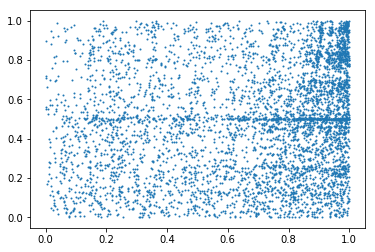

In [561]:
nsamples = 5000
x = dist.sample(nsamples)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = dsigmaTest(x)

xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])

plt.scatter(xPts[:,0],xPts[:,1],s=1)
plt.show()

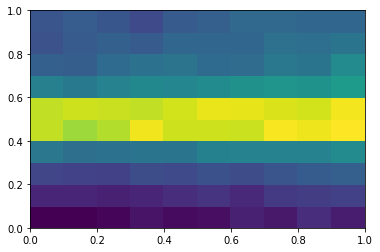

In [544]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts/qPts,norm=mpl.colors.LogNorm())
plt.show()

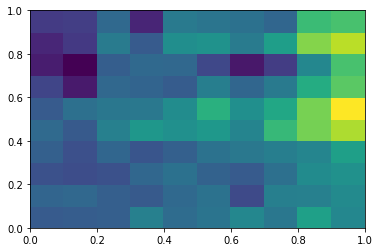

In [545]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=qPts,norm=mpl.colors.LogNorm())
plt.show()

In [547]:
def dsigma_np(x1,x2):
    return (x1**2 + x2**2)/((1-x1)*(1-x2))

def dsigmaTest_np(x1,x2):
    return (1+x1**2)/((90**2-(90*2*(1-x2))**2)**2+2.5**2*90**2)

In [548]:
import scipy.integrate as integrate

print(integrate.dblquad(dsigmaTest_np,0.0,1,0.0,1))

(5.738315882225917e-07, 4.50462926257536e-10)


In [555]:
mean, var = sess.run(tf.nn.moments(dsig/q,axes=[0]))
print('xsec = %e, var = %e' % (mean,var/np.sqrt(nsamples)))

xsec = 5.611313e+00, var = 3.943293e+00


In [462]:
x1 = tf.linspace(0.0,1,100)
x2 = tf.linspace(0.0,1,100)
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=0)),(10000,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])

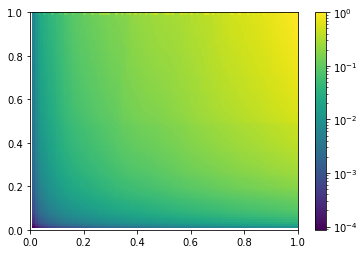

In [463]:
h = plt.hist2d(grid[:,0],grid[:,1],weights=cdf,norm=mpl.colors.LogNorm(),bins=100)
plt.colorbar(h[3])
plt.show()

In [464]:
x = tf.constant([0.8,0.2],shape=(1,2))
Y = dist.cdf(x)
sess.run([x,Y])

[array([[0.8, 0.2]], dtype=float32), array([0.1373798], dtype=float32)]

In [465]:
x = tf.constant([1.0,1.0],shape=(1,2))
Y = dist.cdf(x)
sess.run([x,Y])

[array([[1., 1.]], dtype=float32), array([1.], dtype=float32)]

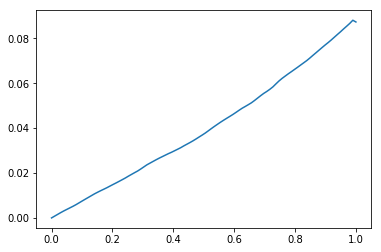

In [466]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.1])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

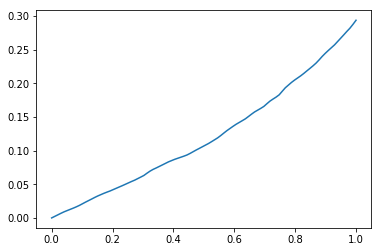

In [467]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.3])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

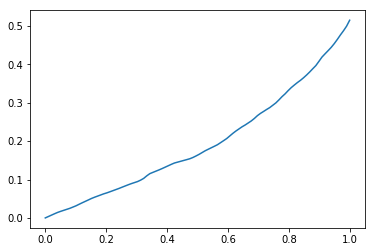

In [468]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.5])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

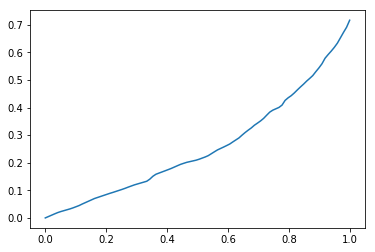

In [469]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.7])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

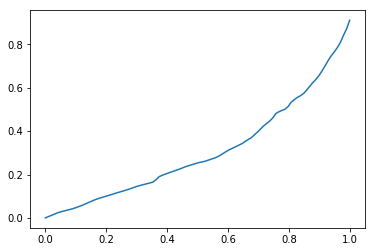

In [470]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.9])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()